## Leitura e Preprocessamento dos Dados

### Requirements

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from unidecode import unidecode
import altair as alt
import re
from pathlib import Path 
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /home/studio-lab-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Leitura e Concatenação 

In [2]:
path = os.getcwd()
files = glob.glob(os.path.join(path, "output/*/*.json"))

In [3]:
jsons = [pd.read_json(file, lines=True) for file in files]
df = pd.concat(jsons, ignore_index=True)

df["subject"] = [os.path.split(os.path.dirname(file))[-1] for file in files]

In [4]:
df.head()

,title,abstract,subject
0,Modelagem de reforma catalítica seca de metano...,Estamos vivenciando o início da Era da Informa...,machinelearning
1,Aplicação de machine learning para apostas esp...,As práticas esportivas surgiram de atividades ...,machinelearning
2,Social machines: a unified paradigm to describ...,"The open, distributed approach of the Web and ...",machinelearning
3,Um método de aprendizagem seqüencial com filtr...,"Em aplicações de aprendizagem de máquina, é co...",machinelearning
4,Development of machine and deep learning based...,Artificial intelligence-based algorithms have ...,machinelearning


In [5]:
df['input'] = df.title + " " + df.abstract

In [6]:
df.head()

,title,abstract,subject,input
0,Modelagem de reforma catalítica seca de metano...,Estamos vivenciando o início da Era da Informa...,machinelearning,Modelagem de reforma catalítica seca de metano...
1,Aplicação de machine learning para apostas esp...,As práticas esportivas surgiram de atividades ...,machinelearning,Aplicação de machine learning para apostas esp...
2,Social machines: a unified paradigm to describ...,"The open, distributed approach of the Web and ...",machinelearning,Social machines: a unified paradigm to describ...
3,Um método de aprendizagem seqüencial com filtr...,"Em aplicações de aprendizagem de máquina, é co...",machinelearning,Um método de aprendizagem seqüencial com filtr...
4,Development of machine and deep learning based...,Artificial intelligence-based algorithms have ...,machinelearning,Development of machine and deep learning based...


In [7]:
df.describe()

,title,abstract,subject,input
count,60,60,60,60
unique,60,60,6,60
top,Modelagem de reforma catalítica seca de metano...,Estamos vivenciando o início da Era da Informa...,machinelearning,Modelagem de reforma catalítica seca de metano...
freq,1,1,10,1


### Stopwords

English and portuguese

In [8]:
languages = ['english', 'portuguese']

In [9]:
list_stop = stopwords.words(languages)
print(list_stop[:10])
print(list_stop[-10:])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
['tivessem', 'tivéssemos', 'tu', 'tua', 'tuas', 'um', 'uma', 'você', 'vocês', 'vos']


### Preprocessing

In [10]:
corpus = df.input.copy()
preprocessed_corpus = []

for abstract in corpus:
    
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(abstract))
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower()
    
    #Normalize
    document = unidecode(document)
    
    document = document.split()
    
    document = [word for word in document if word not in list_stop and word.isalpha()]
    
    document = " ".join(document)
        
    preprocessed_corpus.append(document)

In [11]:
print(len(corpus))
print(len(preprocessed_corpus))

60
60


### Feature Extration

In [12]:
count_vect = CountVectorizer(stop_words=list_stop, min_df=0.05, max_df=0.99)
count_vect.fit(preprocessed_corpus)

CountVectorizer(max_df=0.99, min_df=0.05,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [13]:
print('Tamanho do vocabulário: ', len(count_vect.vocabulary_))
counter = 0
for _, count in count_vect.vocabulary_.items():
    counter += count
    
print('Quantidade total de palavras: ', counter)

Tamanho do vocabulário:  584
Quantidade total de palavras:  170236


#### TF-IDF

In [14]:
X = count_vect.transform(preprocessed_corpus)

In [15]:
X.shape

(60, 584)

In [16]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X)

TfidfTransformer()

In [17]:
X_tfidf = tfidf_transformer.transform(X)

In [18]:
X_tfidf.shape

(60, 584)

In [19]:
count_vect.get_feature_names_out()

array(['abordagem', 'abordagens', 'acerca', 'acesso', 'acoes', 'acordo',
       'adjacentes', 'adultos', 'agrupamento', 'agua', 'ainda', 'alem',
       'algumas', 'alguns', 'aliada', 'alta', 'alteracoes', 'alto',
       'ambas', 'ambientais', 'ambiental', 'ambiente', 'ambientes',
       'ambos', 'analisada', 'analisadas', 'analisados', 'analisar',
       'analise', 'analises', 'ano', 'anos', 'apenas', 'apesar',
       'aplicacao', 'apontam', 'apos', 'aprendizagem', 'apresenta',
       'apresentado', 'apresentam', 'apresentando', 'apresentar',
       'apresentaram', 'apresentou', 'aproximadamente', 'aquecimento',
       'area', 'areas', 'arquitetos', 'arquitetura', 'arte', 'artes',
       'artigos', 'artisticos', 'aspectos', 'assim', 'ate', 'atencao',
       'atividade', 'atividades', 'atlantica', 'atraves', 'aumento',
       'avaliacao', 'avaliadas', 'avaliados', 'avaliar', 'avanco',
       'baixa', 'baixo', 'base', 'bases', 'basica', 'basico', 'bem',
       'bens', 'boa', 'brasil', 'b

### Análise das Caracteristicas textuais

In [20]:
sorted_X_indices = np.argsort(X.toarray(), axis=1)[:, ::-1]
sorted_Xtfidf_indices = np.argsort(X_tfidf.toarray(), axis=1)[:,::-1]

print('Termos mais comuns nos 10 primeiros documentos:')
for i in range(10):
    print(count_vect.get_feature_names_out()[sorted_X_indices[i, :3]])

print('\nTermos mais relevantes nos 10 primeiros documentos:')
for i in range(10):
    print(count_vect.get_feature_names_out()[sorted_Xtfidf_indices[i, :3]])

Termos mais comuns nos 10 primeiros documentos:
['gas' 'processos' 'modelos']
['dados' 'regressao' 'resultados']
['social' 'machines' 'software']
['metodo' 'aprendizagem' 'machine']
['context' 'models' 'support']
['acesso' 'atraves' 'metodo']
['imagens' 'meio' 'neural']
['learning' 'svm' 'machine']
['learning' 'network' 'performance']
['series' 'time' 'performance']

Termos mais relevantes nos 10 primeiros documentos:
['gas' 'modelos' 'processos']
['regressao' 'svm' 'dados']
['social' 'machines' 'software']
['aprendizagem' 'metodo' 'learning']
['context' 'models' 'support']
['acesso' 'software' 'feita']
['imagens' 'meio' 'network']
['svm' 'machine' 'learning']
['network' 'learning' 'performance']
['series' 'time' 'performance']


### Visualisation

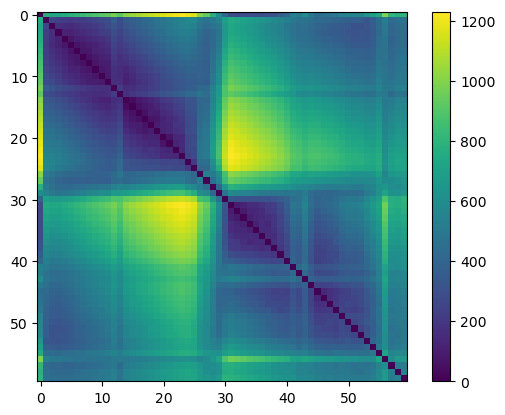

In [21]:
p = pairwise_distances(np.argsort(X_tfidf.toarray(), axis=0)[:,::-1], metric='euclidean')
plt.imshow(p, interpolation='nearest')
plt.colorbar()

In [22]:
tfidf_df = pd.DataFrame(X_tfidf.toarray(), index=df['subject'], columns=count_vect.get_feature_names_out())
tfidf_df = tfidf_df.groupby('subject').mean()
tfidf_df.head()

,abordagem,abordagens,acerca,acesso,acoes,acordo,adjacentes,adultos,agrupamento,agua,...,velocidade,vem,verificar,verificou,vez,viabilidade,vida,visando,vista,way
subject,,,,,,,,,,,,,,,,,,,,,
aquecimento_global,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013315,0.000000,0.000000,0.032269,...,0.070469,0.000000,0.000000,0.024768,0.000000,0.024083,0.009596,0.035832,0.006694,0.000000
bauhaus_arquitetura,0.000000,0.010627,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.009495,0.000000,0.006802,0.000000,0.000000,0.007447,0.000000,0.020085,0.000000
economiabrasileira,0.026973,0.011105,0.012709,0.000000,0.000000,0.009049,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.007824,0.028003,0.007365,0.000000,0.000000,0.000000,0.000000,0.000000
genetica,0.000000,0.000000,0.007324,0.000000,0.007324,0.005428,0.012751,0.019966,0.035925,0.000000,...,0.000000,0.000000,0.022804,0.000000,0.030491,0.007084,0.000000,0.005102,0.011654,0.000000
machinelearning,0.006626,0.007436,0.000000,0.045403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.008412,0.000000,0.022011,0.000000,0.008412,0.008874,0.000000,0.038176


In [23]:
tfidf_df = tfidf_df.stack().reset_index()
tfidf_df.head()

,subject,level_1,0
0,aquecimento_global,abordagem,0.0
1,aquecimento_global,abordagens,0.0
2,aquecimento_global,acerca,0.0
3,aquecimento_global,acesso,0.0
4,aquecimento_global,acoes,0.0


In [24]:
tfidf_df = tfidf_df.rename(columns={0:'TFIDF', 'subject': 'Tema','level_1': 'Termo'})
tfidf_df

,Tema,Termo,TFIDF
0,aquecimento_global,abordagem,0.000000
1,aquecimento_global,abordagens,0.000000
2,aquecimento_global,acerca,0.000000
3,aquecimento_global,acesso,0.000000
4,aquecimento_global,acoes,0.000000
...,...,...,...
3499,saudeinfantil,viabilidade,0.000000
3500,saudeinfantil,vida,0.010549
3501,saudeinfantil,visando,0.000000
3502,saudeinfantil,vista,0.007628


In [25]:
top_tfidf = tfidf_df.sort_values(by=['Tema','TFIDF'], ascending=[True,False]).groupby(['Tema']).head(3)
top_tfidf

,Tema,Termo,TFIDF
46,aquecimento_global,aquecimento,0.180217
513,aquecimento_global,sistema,0.092203
536,aquecimento_global,temperatura,0.087118
734,bauhaus_arquitetura,design,0.286022
634,bauhaus_arquitetura,arquitetura,0.146705
635,bauhaus_arquitetura,arte,0.137423
1351,economiabrasileira,economia,0.294540
1317,economiabrasileira,desenvolvimento,0.084932
1247,economiabrasileira,brasileira,0.078933
2000,genetica,genetica,0.338570


In [26]:
# adding a little randomness to break ties in term ranking
top_tfidf_plusRand = top_tfidf.copy()
top_tfidf_plusRand['TFIDF'] = top_tfidf_plusRand['TFIDF'] + np.random.rand(top_tfidf.shape[0])*0.0001

# base for all visualizations, with rank calculation
base = alt.Chart(top_tfidf_plusRand).encode(
    x = 'rank:O',
    y = 'Tema:N'
).transform_window(
    rank = "rank()",
    sort = [alt.SortField("TFIDF", order="descending")],
    groupby = ["Tema"],
)

# heatmap specification
heatmap = base.mark_rect().encode(
    color = 'TFIDF:Q'
)

# text labels, white for darker heatmap colors
text = base.mark_text(baseline='middle').encode(
    text = 'Termo:N',
    color = alt.condition(alt.datum.TFIDF >= 0.2, alt.value('white'), alt.value('black'))
)

# display the three superimposed visualizations
(heatmap + text).properties(width = 600)

/home/studio-lab-user/.conda/envs/NLP/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

## Topic Modelling

In [27]:
from sklearn.decomposition import TruncatedSVD, NMF

### NMF: Non-Negative Matrix Factorization  

In [28]:
def get_explained_var_nmf(n_components, X_tfidf):
    model = NMF(n_components=n_components, random_state=0, max_iter=150, solver='mu')
    model.fit(X_tfidf)
    return model.reconstruction_err_

In [29]:
elbow_mnf = []

for n_components in range(1, 100):
    var = get_explained_var_nmf(n_components, X_tfidf)
    elbow_mnf.append(var)  

/home/studio-lab-user/.conda/envs/NLP/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 150 reached. Increase it to improve convergence.
  warnings.warn(


<AxesSubplot: >

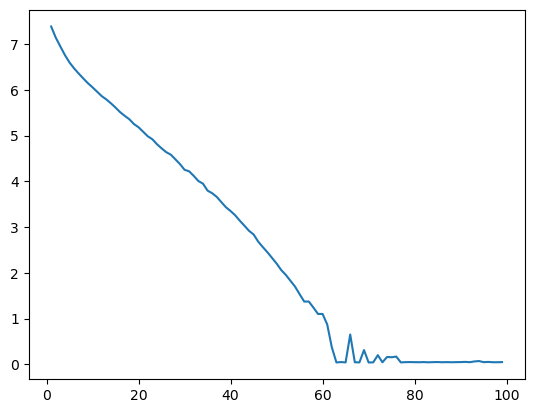

In [30]:
sns.lineplot(x=range(1, 100), y=elbow_mnf)

### Truncated SVD (aka Latent Semantic Analysis or LSA)

In [31]:
def get_explained_var_svd(n_components, X_tfidf):
    svd = TruncatedSVD(n_components=n_components, n_iter=10 , random_state=0)
    svd.fit(X_tfidf)
    return sum(svd.explained_variance_ratio_)

In [32]:
elbow_svd = []

for n_components in range(1, 100):
    var = get_explained_var_svd(n_components, X_tfidf)
    elbow_svd.append(var)    

<AxesSubplot: >

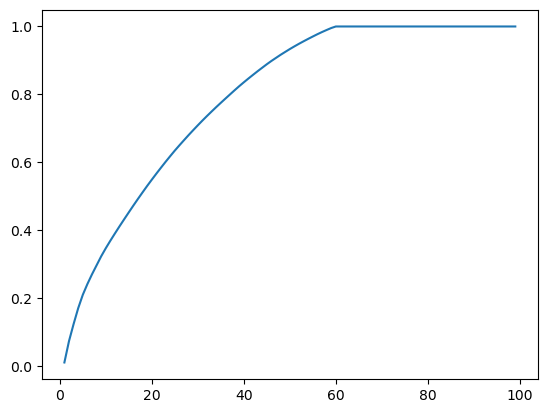

In [33]:
sns.lineplot(x=range(1, 100), y=elbow_svd)

In [34]:
svd = TruncatedSVD(n_components=20, n_iter=100, random_state=0)
svd.fit(X_tfidf)

TruncatedSVD(n_components=20, n_iter=100, random_state=0)

In [35]:
print('Total de variabilidade explicada: ', sum(svd.explained_variance_ratio_))

Total de variabilidade explicada:  0.5491842291887832


In [36]:
X_tfidf.shape

(60, 584)

In [37]:
svd_components_df = pd.DataFrame(svd.components_, columns=count_vect.get_feature_names_out())
print(svd_components_df.shape)
svd_components_df.head()

(20, 584)


,abordagem,abordagens,acerca,acesso,acoes,acordo,adjacentes,adultos,agrupamento,agua,...,velocidade,vem,verificar,verificou,vez,viabilidade,vida,visando,vista,way
0,0.027006,0.014682,0.017393,0.021911,0.014875,0.015243,0.016387,0.016156,0.028193,0.018993,...,0.027496,0.013228,0.027743,0.033124,0.037086,0.016796,0.020908,0.024486,0.027917,0.004986
1,-0.026778,-0.013158,-0.000647,-0.017275,0.001310,-0.001583,0.015487,0.027339,0.046157,-0.010467,...,-0.006255,-0.012858,0.010724,-0.024870,0.030729,0.005459,-0.017041,-0.003170,-0.002910,-0.010180
2,0.009075,-0.017323,-0.002122,-0.005599,0.020384,0.002708,-0.004181,0.000629,-0.002553,0.001630,...,-0.009693,0.010792,0.003337,-0.012232,-0.020142,-0.005819,0.005910,-0.013056,-0.010210,-0.039881
3,0.003865,-0.002311,-0.006716,0.034598,0.006511,-0.001010,-0.001891,0.001211,-0.000596,0.003241,...,0.002620,-0.002258,0.008892,-0.012891,0.018328,-0.001643,0.007863,0.003557,-0.017546,0.074856
4,-0.029368,-0.007644,-0.018513,-0.002514,0.007542,-0.007878,-0.006213,0.004008,0.001294,-0.031719,...,-0.052676,0.012199,-0.006798,-0.049626,-0.006984,-0.018463,-0.001819,-0.025021,0.033803,0.024831


In [38]:
len(svd.components_)

20

In [39]:
X_topics = svd.components_
n_top_words = 20

for topic in range(len(svd.components_)):
    tokens_t_k = np.argsort(X_topics[topic,:])[-n_top_words:][::-1]
    print(f'Tópico {topic}: \n', count_vect.get_feature_names_out()[tokens_t_k], '\n')

Tópico 0: 
 ['genetica' 'populacoes' 'saude' 'economia' 'infantil' 'design'
 'desenvolvimento' 'sobre' 'dados' 'trabalho' 'mortalidade' 'pernambuco'
 'diversidade' 'analise' 'estudo' 'sao' 'especie' 'recife' 'nao'
 'resultados'] 

Tópico 1: 
 ['genetica' 'populacoes' 'diversidade' 'especie' 'conservacao' 'especies'
 'estruturacao' 'diferenciacao' 'variabilidade' 'areas' 'individuos'
 'atlantica' 'loci' 'marcadores' 'issr' 'nm' 'populacional' 'estuarios'
 'sugerindo' 'variacao'] 

Tópico 2: 
 ['saude' 'infantil' 'mortalidade' 'criancas' 'per' 'familia' 'renda'
 'educacao' 'estrategia' 'taxas' 'instrumento' 'crianca' 'atencao'
 'sociais' 'reducao' 'condicoes' 'desenvolvimento' 'programa' 'impacto'
 'diferencas'] 

Tópico 3: 
 ['learning' 'machine' 'time' 'context' 'deep' 'series' 'support' 'saude'
 'neural' 'svm' 'network' 'performance' 'models' 'results' 'information'
 'obtained' 'machines' 'three' 'different' 'datasets'] 

Tópico 4: 
 ['design' 'arte' 'saude' 'arquitetura' 'infantil' '

<AxesSubplot: >

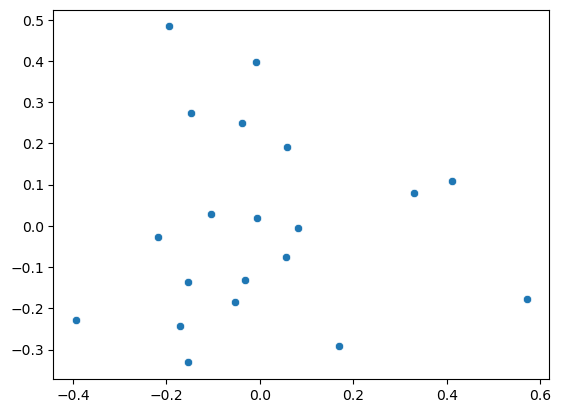

In [40]:
X_topics_2d = PCA(n_components=2, random_state=0).fit_transform(X_topics)

sns.scatterplot(X_topics_2d, x=X_topics_2d[:, 0], y=X_topics_2d[:, 1])

In [41]:
print(X_topics.shape)
print(X_tfidf.shape)

(20, 584)
(60, 584)


In [42]:
svd_X = svd.transform(X_tfidf)
svd_X.shape

(60, 20)

### Text Classification using LSA

In [43]:
y = list(df.subject.copy())

X_train, X_test, y_train, y_test = train_test_split(svd_X, y, test_size=0.33, random_state=0)

In [44]:
clf = RandomForestClassifier(random_state=0)

In [45]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [46]:
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

In [47]:
print("Train Dataset Metrics")
print(classification_report(y_train, y_pred_train))
print("--------------------------------")
print("Test Dataset Metrics")
print(classification_report(y_test, y_pred_test))

Train Dataset Metrics
                     precision    recall  f1-score   support

 aquecimento_global       1.00      1.00      1.00         8
bauhaus_arquitetura       1.00      1.00      1.00         7
 economiabrasileira       1.00      1.00      1.00         7
           genetica       1.00      1.00      1.00         5
    machinelearning       1.00      1.00      1.00         7
      saudeinfantil       1.00      1.00      1.00         6

           accuracy                           1.00        40
          macro avg       1.00      1.00      1.00        40
       weighted avg       1.00      1.00      1.00        40

--------------------------------
Test Dataset Metrics
                     precision    recall  f1-score   support

 aquecimento_global       1.00      1.00      1.00         2
bauhaus_arquitetura       0.75      1.00      0.86         3
 economiabrasileira       1.00      1.00      1.00         3
           genetica       1.00      1.00      1.00         5
    m

## Word2Vec

In [48]:
from gensim.test.utils import datapath
from gensim.models import Word2Vec
from gensim import utils
import multiprocessing

In [49]:
cores = multiprocessing.cpu_count() 
cores

4

In [50]:
documents = df.input

documents_tokens = []
for document in documents:
    documents_tokens.append(
        [unidecode(token.lower()) for token in word_tokenize(document, language='portuguese') if token not in list_stop and token.isalpha()]
    )

In [51]:
documents_tokens

[['modelagem',
  'reforma',
  'catalitica',
  'seca',
  'metano',
  'gas',
  'sintese',
  'utilizando',
  'machine',
  'learning',
  'redes',
  'neurais',
  'estamos',
  'vivenciando',
  'inicio',
  'era',
  'informacao',
  'onde',
  'enormes',
  'quantidades',
  'dados',
  'geradas',
  'cada',
  'instante',
  'principalmente',
  'decorrencia',
  'rapida',
  'modernizacao',
  'desenvolvimento',
  'tecnologico',
  'tem',
  'acontecido',
  'diversos',
  'setores',
  'sociedade',
  'com',
  'ambito',
  'industrias',
  'presenciando',
  'desenrolar',
  'revolucao',
  'industrial',
  'industria',
  'fortemente',
  'marcada',
  'automacao',
  'inteligencia',
  'artificial',
  'big',
  'data',
  'essa',
  'revolucao',
  'novas',
  'tecnologias',
  'trazidas',
  'podem',
  'trazer',
  'grandes',
  'melhorias',
  'industria',
  'modificando',
  'relacoes',
  'trabalho',
  'aumentando',
  'significativamente',
  'eficiencia',
  'seguranca',
  'qualidade',
  'processos',
  'industriais',
  'uma',

In [52]:
w2v_model = Word2Vec(
          min_count=5,
          window=3,
          vector_size=500, 
          alpha=0.03, 
          min_alpha=0.0007, 
          negative=20,
          workers=4
        )

In [53]:
w2v_model.build_vocab(corpus_iterable=documents_tokens)

w2v_model.train(documents_tokens, total_examples=w2v_model.corpus_count, epochs=5, report_delay=1)

(19397, 47425)

In [54]:
w2v_model.get_latest_training_loss()

0.0

In [55]:
print("Tamanho do vocabulário: ", len(w2v_model.wv))

Tamanho do vocabulário:  465


In [56]:
w2v_model.wv['machine']

array([ 0.24881469, -0.02389963,  0.13661872,  0.1919267 , -0.00414241,
       -0.1863828 , -0.09721931,  0.00901647,  0.24020685, -0.09915481,
        0.12063459, -0.03447985, -0.19118622, -0.08653656,  0.02205688,
       -0.16817065, -0.10282379, -0.10525021, -0.05086271,  0.08876357,
       -0.07837159, -0.06015347,  0.1143399 , -0.162609  , -0.10138162,
       -0.0306512 ,  0.0462204 ,  0.08332925, -0.15924084,  0.16874242,
        0.1631142 , -0.10696064, -0.1280924 , -0.10640864,  0.01695634,
       -0.05937276, -0.11013744, -0.14207867,  0.08399832, -0.2635369 ,
        0.14472048,  0.02086726, -0.11238973, -0.04828378, -0.00275389,
       -0.19690834,  0.06008817,  0.08105458,  0.02740715, -0.04883817,
       -0.17218418, -0.0487175 , -0.0610363 , -0.27441314,  0.0507512 ,
       -0.13289604,  0.07176709, -0.1837444 ,  0.06332736,  0.06011227,
        0.0998897 ,  0.13471349,  0.14496692,  0.36266726,  0.03427427,
        0.00828693, -0.01550222, -0.04143731,  0.03858628, -0.04

In [62]:
w2v_model.wv.most_similar('machine')

[('learning', 0.9999381303787231),
 ('a', 0.999937891960144),
 ('maior', 0.9999361038208008),
 ('saude', 0.9999359846115112),
 ('estudo', 0.9999352693557739),
 ('meio', 0.9999332427978516),
 ('metodos', 0.9999327063560486),
 ('objetivo', 0.9999324083328247),
 ('social', 0.9999313950538635),
 ('populacoes', 0.9999305605888367)]